In [15]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('cleaned_data.csv')


# Step 2: Ensure correct datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Step 3: Set today's date as the latest transaction date
today = df['invoice_date'].max()

# Step 4: Create RFM Table with correct frequency calculation
# First calculate number of unique invoices per customer (true frequency)
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (today - x.max()).days,   # Recency
    'invoice_no': 'nunique',                           # Frequency (corrected)
    'Total': 'sum'                                     # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Step 5: Calculate loyalty score (normalized frequency)
# Use percentile ranking to handle cases with little variation
rfm['loyalty_score'] = rfm['frequency'].rank(pct=True) * 100

# Step 6: Prepare features and scale them
features = rfm[['recency', 'frequency', 'monetary', 'loyalty_score']].fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 7: Apply Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
rfm['gmm_segment'] = gmm.fit_predict(scaled_features)

# Step 8: Segment Summary Table
segment_summary = rfm.groupby('gmm_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'loyalty_score': 'mean',
    'customer_id': 'count'  # Add count of customers in each segment
}).round(2)

print(segment_summary)

             recency  frequency  monetary  loyalty_score  customer_id
gmm_segment                                                          
0             396.06        1.0    152.69           50.0        46615
1             397.42        1.0   8127.62           50.0        25370
2             600.26        1.0   1398.39           50.0        14101
3             182.59        1.0   1372.95           50.0        13252


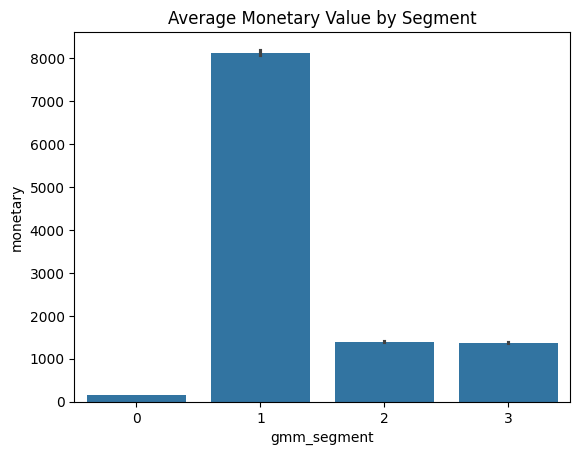

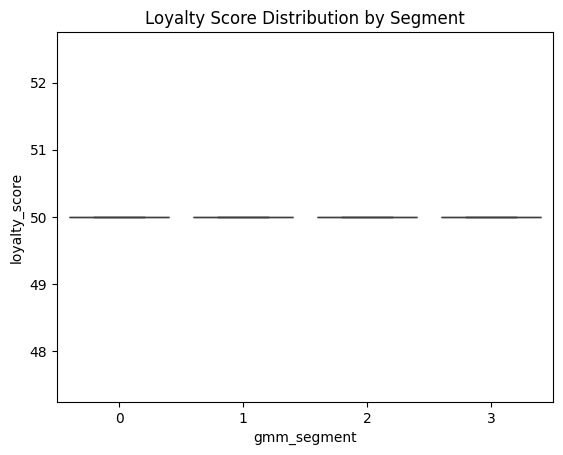

In [16]:
# Bar plot for monetary value
sns.barplot(x='gmm_segment', y='monetary', data=rfm)
plt.title("Average Monetary Value by Segment")
plt.show()

# Box plot for loyalty score
sns.boxplot(x='gmm_segment', y='loyalty_score', data=rfm)
plt.title("Loyalty Score Distribution by Segment")
plt.show()

In [17]:
# Save the RFM DataFrame to a CSV file
rfm.to_csv('rfm_data.csv', index=False)
